<a href="https://colab.research.google.com/github/cristianexer/tmp/blob/main/2020_11_06_Twitch_Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring node2vec

Objectives:
 - Research and understand node2vec concept and module's API
 - Explore node2vec capabilities, applications and limitations
 - Implement a link prediction model to predict social links of Twitch streamers


## Node2Vec

References:
- [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)

### What is node2vec ?

Is an algorithmic framework for learning continuous feature representations for nodes in networks.

![](https://cdn-images-1.medium.com/max/932/1*dIHSCxk8ZAR7vI7Fm3iw9A.png)

### How does it work (high-level) ?

ndoe2vec simulates random walks to learn the representations for all the nodes in the network, while sampling nodes at every walk stop based on 2nd order Markov chain transition probabilities, using Alias Sampling for efficient sampling and using SGD (Stochastic Gradient Descent) as objective function for optimization.



## Data

Source: [Twitch Social Network](https://github.com/benedekrozemberczki/datasets#twitch-social-networks)

**Description**

These datasets used for node classification and transfer learning are Twitch user-user networks of gamers who stream in a certain language. Nodes are the users themselves and the links are mutual friendships between them. Vertex features are extracted based on the games played and liked, location and streaming habits. Datasets share the same set of node features, this makes transfer learning across networks possible. These social networks were collected in May 2018. The supervised task related to these networks is binary node classification - one has to predict whether a streamer uses explicit language.


**Properties**

- **Directed:** No.
- **Node features:** Yes.
- **Edge features:** No.
- **Node labels:** Yes. Binary-labeled.
- **Temporal:** No.

**ENGB Data**
- **Nodes:** 7,126
- **Edges:** 35,324 
- **Density:** 0.002
- **Transitvity:** 0.042


**Imports**

In [ ]:
import pandas as pd
import numpy as np
import requests,json
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
from tqdm.notebook import tqdm
tqdm.pandas()
import itertools
plt.style.use('seaborn')

**Load Data**

In [ ]:
%%time
edges = pd.read_csv('https://raw.githubusercontent.com/benedekrozemberczki/datasets/master/twitch/ENGB/ENGB_edges.csv')
features = requests.get('https://raw.githubusercontent.com/benedekrozemberczki/datasets/master/twitch/ENGB/ENGB_features.json').json()
target = pd.read_csv('https://raw.githubusercontent.com/benedekrozemberczki/datasets/master/twitch/ENGB/ENGB_target.csv')

CPU times: user 71.2 ms, sys: 19.8 ms, total: 91.1 ms
Wall time: 888 ms


**Edges**

In [ ]:
print(f'Number of edges: {len(edges)}')
edges[:3]

Number of edges: 35324


,from,to
0,6194,255
1,6194,980
2,6194,2992


**Target**

In [ ]:
print(f'Number of targets: {len(target)}')
target[:3]

Number of targets: 7126


,id,days,mature,views,partner,new_id
0,73045350,1459,False,9528,False,2299
1,61573865,1629,True,3615,False,153
2,171688860,411,True,46546,False,397


**Features**

In [ ]:
for i,(k,v) in enumerate(features.items()):
    print(f'k:{k}\nv:{v}\n')
    if i == 3:
        break

k:3032
v:[2605, 1191, 357, 2120, 861, 231, 3164, 920, 1907, 1612, 2327, 2549, 2524, 2912, 139, 83, 276, 2645, 2424, 2501, 2737, 1525, 751]

k:4032
v:[1521, 1191, 2334, 846, 3103, 3045, 920, 224, 810, 1369, 569, 2384, 2362, 1762, 3106, 751]

k:3945
v:[1550, 3152, 146, 2203, 846, 673, 2063, 920, 224, 3097, 329, 569, 2384, 2645, 608, 2936]

k:4677
v:[308, 3152, 357, 692, 653, 181, 861, 920, 1907, 2185, 1043, 139, 569]



**Since we work with large size networks is recommended to use Plotly for plotting network graphs**

In [ ]:
def plot_network(G,pos_func=nx.kamada_kawai_layout):
    nodes_data = G.nodes(data=True)
    pos=pos_func(G)
    edge_trace = [go.Scatter(
    #   x0                   y0                   None
    x=[ pos.get(edge[0])[0], pos.get(edge[1])[0], None],
    #   x1                   y1                   None
    y=[ pos.get(edge[0])[1], pos.get(edge[1])[1], None],
    line=dict(width=0.2, color='gray'),
    hoverinfo='none',
    mode='lines') for edge in G.edges()]

    # create the nodes in plotly way
    node_trace = [go.Scatter(
        x=[pos.get(node)[0]], 
        y=[pos.get(node)[1]],
        mode='markers',
        text=f'{node} | Connections: {len(adjacencies)}',
        hoverinfo='text',
        
        textposition="middle center",
        textfont=dict(family='Arial',
                    size=10,
                    color='#000'
                    )) for node, adjacencies in G.adjacency()]
    fig = go.Figure(data=edge_trace + node_trace,
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=5,r=5,t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    return fig

**Edges Data**

In [ ]:
G = nx.from_pandas_edgelist(edges[:300],source='from',target='to')
plot_network(G)

## Applications & Capabilities

In [ ]:
try:
    from node2vec import Node2Vec
except:
    !pip install node2vec
    from node2vec import Node2Vec

### Similarity

In [ ]:
G = nx.from_pandas_edgelist(edges,source='from',target='to')

In [ ]:
sim = Node2Vec(G, dimensions=10, walk_length=5, num_walks=10, p=1, q=1,workers=3)

Computing transition probabilities: 100%|██████████| 7126/7126 [00:18<00:00, 389.55it/s] 


In [ ]:
sim_model = sim.fit(window=3, min_count=1)

**Find Similar users by vector**

In [ ]:
similar_users = sim_model.wv.similar_by_vector(sim_model.wv.get_vector('2299'))
similar_users

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('2299', 1.0000001192092896),
 ('229', 0.9975084662437439),
 ('5949', 0.9970887899398804),
 ('4405', 0.9966669082641602),
 ('4981', 0.9964326620101929),
 ('953', 0.9963597655296326),
 ('7088', 0.9958219528198242),
 ('4349', 0.9954524040222168),
 ('6957', 0.9953999519348145),
 ('4589', 0.9938157200813293)]

In [ ]:
def get_edge_list_by(id,graph):
    return [x for x in list(graph.edges()) if x[0] == int(id)]

def get_sub_graph_of_similarity(id,model,graph):
    sim_users = model.wv.similar_by_vector(model.wv.get_vector(id))
    sim_users = [x[0] for x  in sim_users]
    all_edges = [get_edge_list_by(x,graph) for x in sim_users]
    all_edges = list(itertools.chain(*all_edges))
    return graph.edge_subgraph(all_edges)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



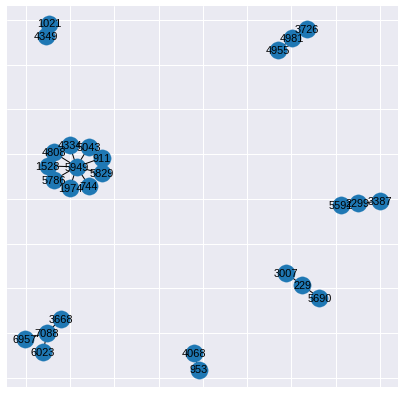

In [ ]:
sim_sub_G = get_sub_graph_of_similarity('2299',sim_model,G);
plt.figure(figsize=(7,7))
nx.draw_networkx(sim_sub_G,pos=nx.spring_layout(sim_sub_G),font_size=11)

### Link Prediction

**Let's generate few fake connections**

In [ ]:
min_node = edges.values.ravel().min()
max_node = edges.values.ravel().max()
fake_nodes = list()
fake_nodes_limit = 5000
counter = 0
pbar = tqdm(total=fake_nodes_limit)
while counter <= fake_nodes_limit:
    frm = np.random.randint(min_node,max_node)
    to = np.random.randint(min_node,max_node)
    if len(edges[(edges['from'] == frm) & (edges['to'] == to)]) == 0:
        pbar.update(counter)
        fake_nodes.append({
            'from': frm,
            'to': to
        })
        counter+=1
fake_nodes = pd.DataFrame(fake_nodes)
fake_nodes['link'] = 0

In [ ]:
data = edges.copy()
data['link'] = 1
data = pd.concat([data,fake_nodes],ignore_index=False)

In [ ]:
data.isnull().sum()

from    0
to      0
link    0
dtype: int64

In [ ]:
G = nx.from_pandas_edgelist(data,'from','to')

In [ ]:
node2vec = Node2Vec(G, dimensions=128, walk_length=16, num_walks=50, workers=3)
# train node2vec model
link_model = node2vec.fit(window=7, min_count=1)


Computing transition probabilities: 100%|██████████| 7126/7126 [00:20<00:00, 355.07it/s] 


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

**Extract the vectors nodes**

In [ ]:
data_vec = data.copy()
data_vec['from_vec'] = data_vec['from'].apply(lambda x: link_model.wv.get_vector(str(x)))
data_vec['to_vec'] = data_vec['to'].apply(lambda x: link_model.wv.get_vector(str(x)))
data_vec['sum_vec'] = data_vec[['from_vec','to_vec']].sum(axis=1)
data_vec

,from,to,link,from_vec,to_vec,sum_vec
0,6194,255,1,"[-1.2367889, -0.69588685, -1.8518809, -0.74786...","[-1.2411073, 0.6700176, -0.27023572, -0.799743...","[-2.4778962, -0.02586925, -2.1221166, -1.54760..."
1,6194,980,1,"[-1.2367889, -0.69588685, -1.8518809, -0.74786...","[-2.9462929, 0.21119362, -2.9769697, -1.445569...","[-4.1830816, -0.48469323, -4.8288507, -2.19343..."
2,6194,2992,1,"[-1.2367889, -0.69588685, -1.8518809, -0.74786...","[0.5413743, -0.48579335, 0.054724805, 0.462075...","[-0.69541454, -1.1816802, -1.7971561, -0.28578..."
3,6194,2507,1,"[-1.2367889, -0.69588685, -1.8518809, -0.74786...","[-1.3365016, 1.3442798, -1.3033663, -2.356617,...","[-2.5732903, 0.6483929, -3.1552472, -3.1044812..."
4,6194,986,1,"[-1.2367889, -0.69588685, -1.8518809, -0.74786...","[-1.7525394, -1.2970957, -1.8276489, 0.7934652...","[-2.9893284, -1.9929825, -3.6795297, 0.0456009..."
...,...,...,...,...,...,...
4996,4320,555,0,"[-0.3509865, -0.9790372, -0.93261707, -0.26836...","[0.43762758, -1.3624817, -0.7472059, -1.269531...","[0.08664107, -2.3415189, -1.6798229, -1.537894..."
4997,1351,722,0,"[1.795631, -0.85302263, -1.4454223, 2.3820598,...","[1.0701022, -0.07921717, -1.2590117, 1.4501349...","[2.8657331, -0.93223983, -2.704434, 3.8321948,..."
4998,2104,4561,0,"[-0.025814213, -0.8629494, -1.2566483, -1.1595...","[-2.117213, -0.77758193, 0.7108264, -1.8299541...","[-2.1430273, -1.6405313, -0.5458219, -2.989487..."
4999,4236,5162,0,"[-0.03634847, 0.26045316, -1.1010358, 0.484648...","[-0.31947285, 1.671326, 0.043540064, 0.5114972...","[-0.3558213, 1.9317791, -1.0574957, 0.99614537..."


**Clustering**

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
clustering_data = pd.DataFrame({
    'node': list(G.nodes)
})
clustering_data['vec'] = clustering_data['node'].apply(lambda x: link_model.wv.get_vector(str(x)))
clustering_data[:3]

,node,vec
0,6194,"[-1.2367889, -0.69588685, -1.8518809, -0.74786..."
1,255,"[-1.2411073, 0.6700176, -0.27023572, -0.799743..."
2,980,"[-2.9462929, 0.21119362, -2.9769697, -1.445569..."


**PCA**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data['vec'].values.tolist())
pca_data = pd.DataFrame({
    'comp_1':pca_data[:,0],
    'comp_2': pca_data[:,1]
})
clustering_data = pd.concat([clustering_data,pca_data],axis=1)
pca_data[:3]

,comp_1,comp_2
0,-2.114130,-0.113253
1,-4.671177,-2.361570
2,-1.217319,1.709426


**Inertia**

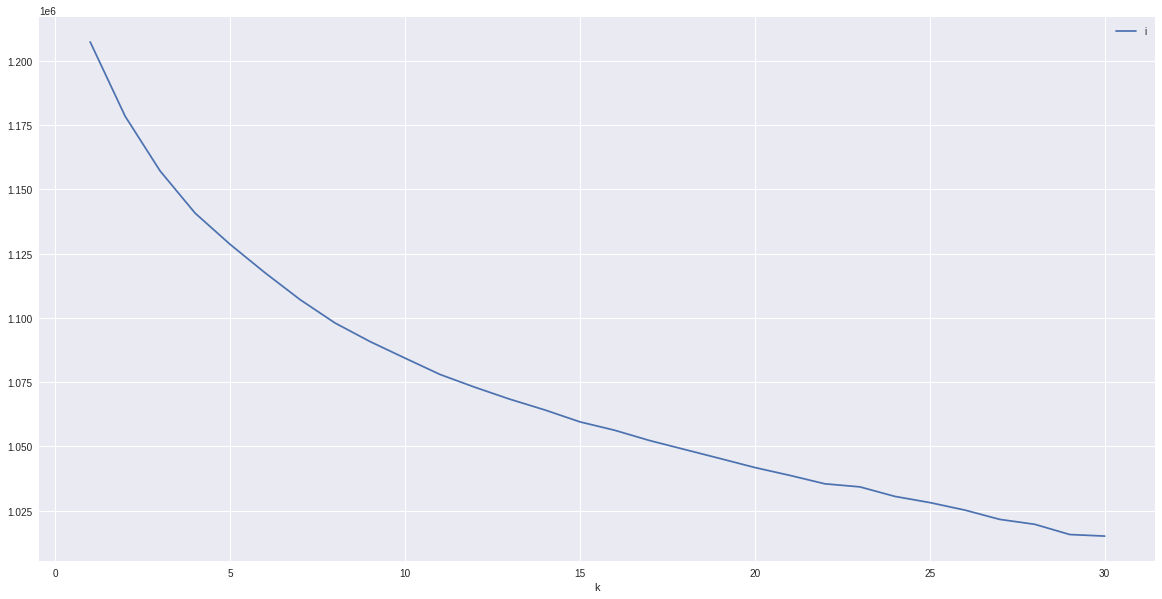

In [ ]:
inertia = list()
for x in tqdm(range(1,31)):
    kmeans = KMeans(n_clusters=x).fit(clustering_data['vec'].values.tolist())
    inertia.append({
        'k': x,
        'i': kmeans.inertia_
    })
inertia = pd.DataFrame(inertia).set_index('k')
inertia.plot(figsize=(20,10));

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k).fit(clustering_data['vec'].values.tolist())
clustering_data['labels'] = kmeans.labels_

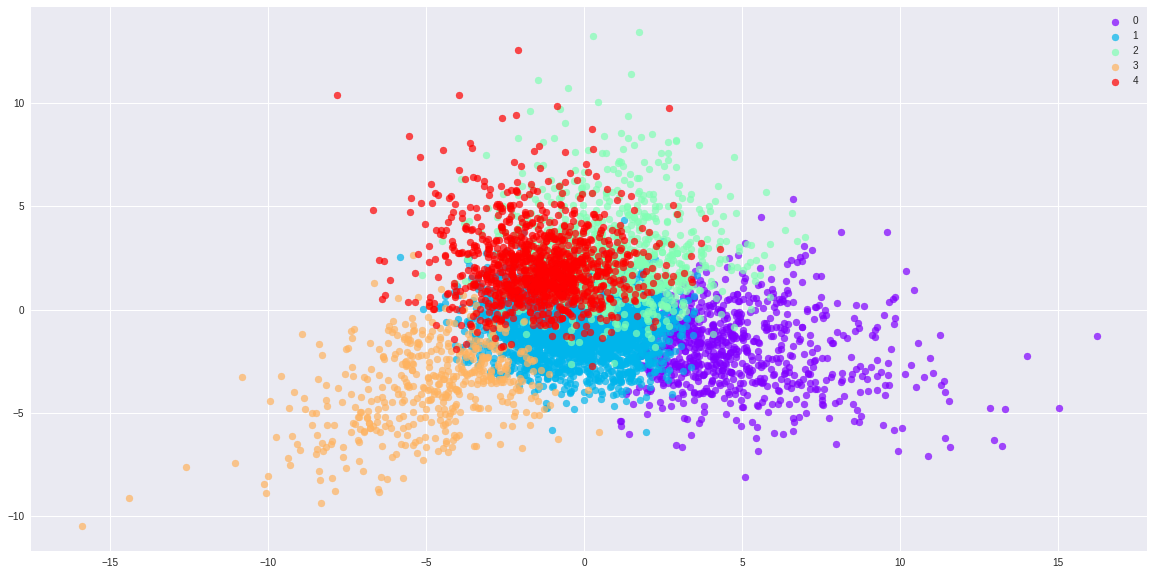

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,k)))
for l in list(range(k)):
    c=next(color)
    d = clustering_data[clustering_data.labels == l]
    ax.scatter(d['comp_1'],d['comp_2'],label=l,color=c,alpha=.7)
ax.legend();

**Split the data into Train / Test**

In [ ]:
train, test = train_test_split(data_vec,test_size=0.33,random_state=42,stratify=data_vec['link'])

**Now let's train few models**

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(train['sum_vec'].values.tolist(), train['link'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
results = test.copy()
results['proba'] = lr.predict_proba(test['sum_vec'].values.tolist())[:,1]

In [ ]:
metrics.roc_auc_score(results['link'],results['proba'])

0.7932123083641355

**XGBoost on Summed vectors**

In [ ]:
import xgboost as xgb

**Balancing the weights**

In [ ]:
scale_pos_weight = np.sqrt(len(train[train.link == 0]) / len(train[train.link == 1]))

**Train model**

In [ ]:
xgc=xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
xgc.fit(pd.DataFrame(train['sum_vec'].values.tolist()),train['link'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.37629182545263473,
              seed=None, silent=None, subsample=1, verbosity=1)

**Results**

In [ ]:
results = test.copy()
results['link_pred'] = xgc.predict(pd.DataFrame(test.sum_vec.values.tolist()))

**Classification Report**

In [ ]:
print(metrics.classification_report(results.link,results.link_pred))

              precision    recall  f1-score   support

           0       0.45      0.44      0.45      1650
           1       0.92      0.92      0.92     11658

    accuracy                           0.86     13308
   macro avg       0.68      0.68      0.68     13308
weighted avg       0.86      0.86      0.86     13308



In [ ]:
metrics.roc_auc_score(results['link'],results['link_pred'])

0.683218078884574

**Confusion Matrix**

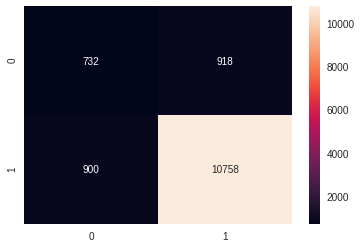

In [ ]:
sns.heatmap(metrics.confusion_matrix(results.link,results.link_pred),annot=True,fmt='d');

**PyTorch**

In [ ]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.deterministic = True  

**Convert values from pandas -> numpy -> torch tensors**

In [ ]:
x_from_train = torch.from_numpy(np.array(train['from_vec'].values.tolist())).type(torch.FloatTensor)
x_to_train = torch.from_numpy(np.array(train['to_vec'].values.tolist())).type(torch.FloatTensor)
y_train = torch.from_numpy(train['link'].values).type(torch.LongTensor)

x_from_test = torch.from_numpy(np.array(test['from_vec'].values.tolist())).type(torch.FloatTensor)
x_to_test = torch.from_numpy(np.array(test['to_vec'].values.tolist())).type(torch.FloatTensor)
y_test = torch.from_numpy(test['link'].values).type(torch.LongTensor)

**Add the train and test tensors into DataLoaders**

In [ ]:
b_size = 256
train_dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_from_train,x_to_train,y_train), batch_size=b_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_from_test,x_to_test,y_test), batch_size=b_size, shuffle=True)

**Create and Train the Model**


Accuracy  : 88.49%
Train loss: 0.2722962200641632
Test loss : 0.27577903866767883


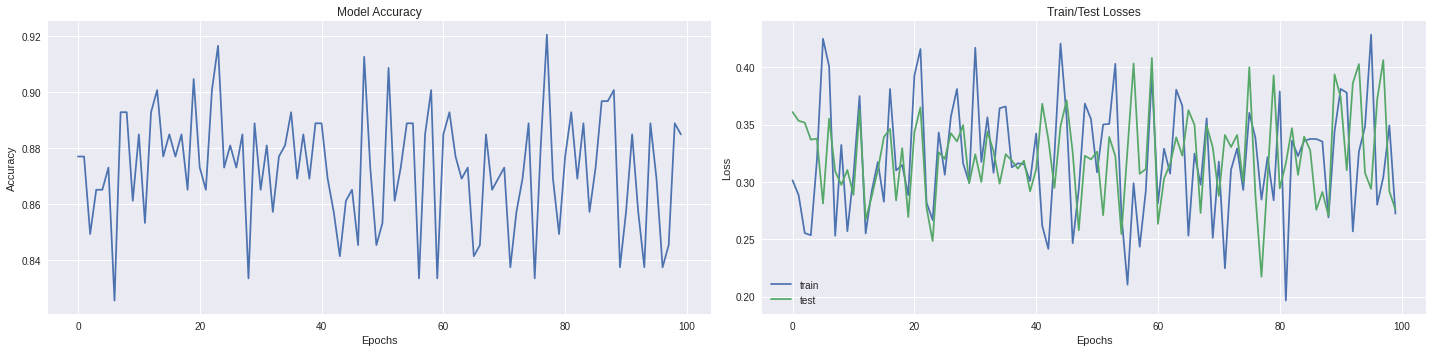

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()

        self.from_lin = nn.Linear(in_features=128,out_features=256)
        self.to_lin = nn.Linear(in_features=128,out_features=256)
        self.lin1 = nn.Linear(in_features=512,out_features=256)
        self.lin2 = nn.Linear(in_features=256,out_features=128)
        self.lin3 = nn.Linear(in_features=128,out_features=2)

    # here we take the input data and pass it through the chain of layers
    def forward(self,frm,to):
        frm = self.from_lin(frm)
        to = self.to_lin(to)
        x = torch.cat((frm,to),dim=1)
        # print(x.size())
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        return x

# instance our model
model = Net()
# set the number of epochs
epochs = 100
# criterion aka loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# create 3 lists to store the losses and accuracy at each epoch
train_losses, test_losses, accuracy = [0]*epochs, [0]*epochs,[0]*epochs


for e in tqdm(range(epochs)):

    for frm,to,label in train_dl:

        optimizer.zero_grad()
        frm = frm.float()
        to = to.float()
        # Comput train loss
        y_pred = model(frm,to)
        loss = criterion(y_pred, label)
        
        loss.backward()

        optimizer.step()

        # store train loss
        train_losses[e] = loss.item()
    
    for frm,to,label in test_dl:    
        # Compute the test stats
        with torch.no_grad():
            # Turn on all the nodes
            model.eval()
            frm = frm.float()
            to = to.float()
            # Comput test loss
            ps = model(frm,to)
            loss = criterion(ps, label)

            # store test loss
            test_losses[e] = loss.item()
            
            # Compute accuracy
            top_p, top_class = ps.topk(1, dim=1)
        
            equals = (top_class == label.view(*top_class.shape))
            
            # store accuracy
            accuracy[e] = torch.mean(equals.type(torch.FloatTensor))

# Print the final information
print(f'Accuracy  : {100*accuracy[-1].item():0.2f}%')
print(f'Train loss: {train_losses[-1]}')
print(f'Test loss : {test_losses[-1]}')
    
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Model Accuracy')
ax[0].plot(accuracy)

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Train/Test Losses')
ax[1].plot(train_losses, label='train')
ax[1].plot(test_losses, label='test')
ax[1].legend()   

plt.tight_layout()

## Conclusions and Limitations

**Main Challanges**
- Understanding and interpreting how the data fits into solving the problem

**Limitations**
- The data has to be defined in a certain way
- Summed vectors or Mean Vectors does not really define the differences between the vector A and B

**Conclusions**
- Node2vec is great for finding similarities between networks or clustering data nodes

**References:**
- [Link Prediction](https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/)